In [ ]:
from contextlib import suppress
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
from zipfile import ZipFile
from skimage.io import imread, imsave
import tensorflow as tf

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pyunpack
!pip install patool
from pyunpack import Archive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 8.6 MB/s eta 0:00:00


In [ ]:
from contextlib import suppress

source_dir = os.path.join('data', 'AID')
with suppress(FileExistsError):
    os.mkdir('data')

In [ ]:
import patoolib

if not os.path.isdir(source_dir):
  patoolib.extract_archive("/content/drive/MyDrive/AID.zip", outdir="data")

patool: Extracting /content/drive/MyDrive/AID.zip ...
patool: running /usr/bin/7z x -odata -- /content/drive/MyDrive/AID.zip
patool: ... /content/drive/MyDrive/AID.zip extracted to `data'.


In [ ]:
class_names = os.listdir(source_dir)   
class_names

['BareLand',
 'Park',
 'SparseResidential',
 'Industrial',
 'BaseballField',
 'School',
 'Square',
 'Desert',
 'Church',
 'River',
 'Port',
 'Beach',
 'Center',
 'Viaduct',
 'RailwayStation',
 'Forest',
 'Stadium',
 'Pond',
 'Meadow',
 'Resort',
 'DenseResidential',
 'Commercial',
 'Playground',
 'Parking',
 'StorageTanks',
 'MediumResidential',
 'Airport',
 'Bridge',
 'Farmland',
 'Mountain']

In [ ]:
flow_base2 = os.path.join('data', 'result')
if not os.path.isdir(flow_base2):
  # Make new directories
  os.mkdir(flow_base2)

In [ ]:
import pandas as pd
df = pd.DataFrame(list())
df.to_csv('/content/data/result/XXX.csv')


In [ ]:
!pip install -q split-folders
import splitfolders
splitfolders.ratio('/content/data/AID', output='/content/data/flow', seed=1337,  ratio=(0.3, 0.5, 0.2))

Copying files: 10000 files [00:20, 481.54 files/s]


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Dense, Reshape
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Add, Concatenate, multiply, GlobalMaxPooling2D

In [ ]:
def cbam_block(cbam_feature, ratio=16):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=16):
	
	channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if tf.keras.backend.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if tf.keras.backend.image_data_format() == "channels_first":
		channel = input_feature._keras_shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if tf.keras.backend.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Reshape, Lambda

from tensorflow.keras.backend import *


In [ ]:
import tensorflow as tf

def outer_product(x1,x2):
    #Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
    phi_I = tf.einsum('ijkm,ijkn->imn',x1,x2)
    
    # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
    phi_I = tf.reshape(phi_I,[-1,x1[0].shape[3]*x[1].shape[3]])
    
    # Divide by feature map size [sizexsize]
    size1 = int(x1[1].shape[1])
    size2 = int(x2[1].shape[2])
    phi_I = tf.divide(phi_I, size1*size2)
    
    # Take signed square root of phi_I
    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))
    
    # Apply l2 normalization
    z_l2 = tf.nn.l2_normalize(y_ssqrt, dim=1)
    return z_l2


In [ ]:
"""
Calculates dot product of x[0] and x[1] for mini_batch 

Assuming both have same size and shape

@param
x -> [ (size_minibatch, total_pixels, size_filter), (size_minibatch, total_pixels, size_filter) ]

"""
def dot_product(x):

    return tf.keras.backend.batch_dot(x[0], x[1], axes=[1,1]) / x[0].get_shape().as_list()[1] 

"""
Calculate signed square root

@param
x -> a tensor

"""

def signed_sqrt(x):

    return tf.keras.backend.sign(x) * tf.keras.backend.sqrt(tf.keras.backend.abs(x) + 1e-9)

"""
Calculate L2-norm

@param
x -> a tensor

"""

def L2_norm(x, axis=-1):

    return tf.keras.backend.l2_normalize(x, axis=axis)


In [ ]:
from tensorflow.keras import Model

In [ ]:
def Resnet50_model1(input_shape, num_classes=30):
  
  model = ResNet50(include_top=False, input_shape=input_shape, pooling='avg', weights= 'imagenet')
  for layer in model.layers[0:-95]:
    layer.trainable = False


  model1 = model.layers[-2].output
  model1 = channel_attention(model1,16)
  #model1 = cbam_block(model1,16)

  #model1 = Flatten()(model1)
  #model1 = Dropout(0.5)(model1)

  model1 = GlobalAveragePooling2D()(model1)
  model1 = Dense(24, activation = "relu")(model1)
  model1 = BatchNormalization()(model1)
  print(model1.shape)
  
  model2 = model.layers[-12].output
  model2 = channel_attention(model2,16)
  #model2 = cbam_block(model2,16)

  #model2 = Flatten()(model2)
  #model2 = Dropout(0.3)(model2)
  model2 = GlobalAveragePooling2D()(model2)
  model2 = Dense(24, activation = "relu")(model2)
  model2 = BatchNormalization()(model2)
  print(model2.shape)
  
  model3 = model.layers[-22].output
  model3 = cbam_block(model3,16)
  #model3 = channel_attention(model3,16)
  #model3 = Flatten()(model3)
  #model3 = Dropout(0.3)(model3)
  model3 = GlobalAveragePooling2D()(model3)
  model3 = Dense(24, activation = "relu")(model3)
  model3 = BatchNormalization()(model3)
  print(model3.shape)
  

  model4 = model.layers[-34].output
  #z4 = model4.shape
  model4 = cbam_block(model4,16)
  #model4 = channel_attention(model4,16)
  #model4 = Flatten()(model4)
  #model4 = Dropout(0.5)(model4)
  #model41 = GlobalMaxPooling2D()(model4)
  model4 = GlobalAveragePooling2D()(model4)
  #model4 = multiply([model41,model4_1])
  model4 = Dense(24, activation = "relu")(model4)
  model4 = BatchNormalization()(model4)
  print(model4.shape)
  
  model5 = model.layers[-96].output
  #model5 = channel_attention(model5,16)
  model5 = cbam_block(model5,16)
  #model5 = Flatten()(model5)
  #model5 = Dropout(0.5)(model5)
  #model51 = GlobalMaxPooling2D()(model5)
  model5 = GlobalAveragePooling2D()(model5)
  #model5 = multiply([model51,model5_1])

  model5 = Dense(24, activation = "relu")(model5)
  model5 = BatchNormalization()(model5)
  print(model5.shape)

  x = Concatenate()([model1, model2, model3, model4, model5])
  
  #x = GlobalAveragePooling2D()(x)
  # output layer
  predictions = Dense(30, activation="softmax")(x)

  model = tf.keras.Model(inputs = model.input, outputs = predictions)
  return model

In [ ]:
def Resnet50model1(input_shape, num_classes=30):
  
  model = ResNet50(include_top=False, input_shape=input_shape, pooling='avg', weights= 'imagenet')
  for layer in model.layers:
    layer.trainable = True

  model1 = model.layers[-2].output
  model1 = GlobalAveragePooling2D()(model1)
  predictions = Dense(30, activation="softmax")(model1)

  model = tf.keras.Model(inputs = model.input, outputs = predictions)
  return model


In [ ]:

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import dot
from tensorflow.keras.layers import Input

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.optimizers import Adam,Nadam, SGD
#from models.model import LCNN_BFF

trainset_dir = '/content/data/flow/train'
valset_dir = '/content/data/flow/test/'
testset_dir = '/content/data/flow/val'
num_classes = 30
learning_rate = 1e-2
momentum = 0.9
batch_size = 16
input_shape = (256, 256, 3)
"""
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 60,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest')"""
train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=preprocess_input,
        rotation_range = 0-60,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest')
val_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    trainset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    valset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical', shuffle = False)
test_generator = val_datagen.flow_from_directory(
    testset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical', shuffle = False)

optim = SGD(learning_rate=learning_rate, momentum=momentum)
# optim = RMSprop(lr=learning_rate)
# optim = Adam(amsgrad=True)
model = Resnet50_model1(input_shape, num_classes = 30 )
#model = UtkMultiOutputModel().model_final(input_shape, num_classes = 45 )

Found 3489 images belonging to 30 classes.
Found 2018 images belonging to 30 classes.
Found 4493 images belonging to 30 classes.
94765736/94765736 [==============================] - 6s 0us/step
(None, 24)
(None, 24)
(None, 24)
(None, 24)
(None, 24)


In [ ]:

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
optim = SGD(learning_rate=0.001, momentum = 0.9)

model.load_weights("/content/drive/MyDrive/model_save/AID/20model.h5")

In [ ]:
loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.05)

In [ ]:
model.compile(optimizer=optim, loss=loss, metrics=['acc'])

csv_path = '/content/data/result/XXX.csv'

In [ ]:
save_weights_path = '/content/drive/MyDrive/model_save/AID/20model.h5'
#You can modify the path by yourself

checkpoint = ModelCheckpoint(save_weights_path, monitor='val_acc', verbose=1, 
                             save_weights_only=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=32, verbose=1)
# logging = TensorBoard(log_dir=log_dir, batch_size=batch_size)
csvlogger = CSVLogger(csv_path, append=True)

callbacks = [checkpoint, reduce_lr, csvlogger]

num_epochs = 100

model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=num_epochs,
          verbose=1, 
          callbacks=callbacks, 
          validation_data=test_generator, 
          validation_steps=len(test_generator),
          workers=1)

In [ ]:
_, acc = model.evaluate(test_generator)
print("Test Accuracy: {}%".format(acc*100))

281/281 [==============================] - 47s 168ms/step - loss: 0.5344 - acc: 0.9584
Test Accuracy: 95.83796858787537%


In [ ]:
test_score = model.evaluate_generator(val_generator, batch_size)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

<ipython-input-30-f98d13d09986>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_score = model.evaluate_generator(val_generator, batch_size)


[INFO] accuracy: 99.61%
[INFO] Loss:  0.4169226586818695


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.figure(figsize=(20,20))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=21)
  plt.yticks(tick_marks, classes)
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xticks(rotation=90)
    plt.xlabel('Predicted label')

<ipython-input-32-ddc5f57d14d9>:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(val_generator)


Confusion Matrix
Normalized confusion matrix


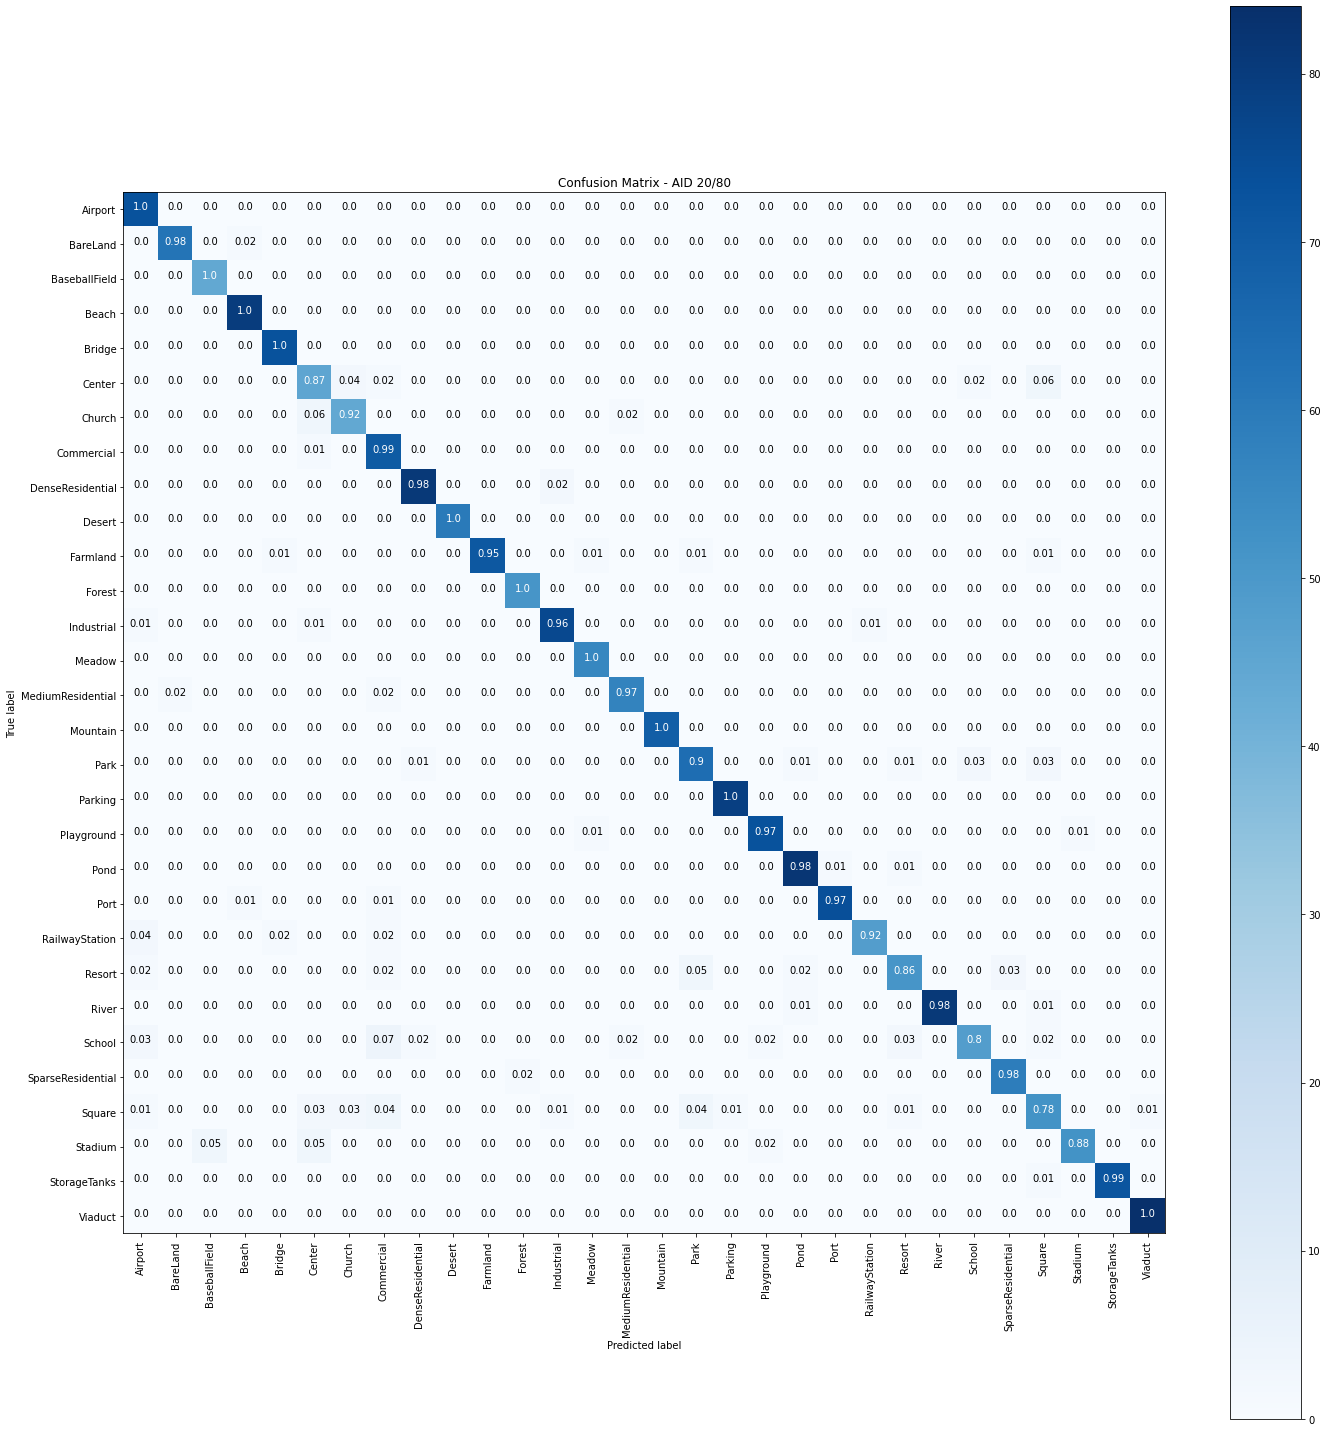

In [ ]:
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(val_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix - AID 20/80')


In [ ]:
clsf_report = pd.DataFrame(classification_report(val_generator.classes, y_pred, target_names=target_names, output_dict=True)).transpose()
print(clsf_report.to_csv('/content/data/result/clsf_report.csv', index= True))

None


In [ ]:
print(clsf_report)

                   precision    recall  f1-score      support
Airport             0.912500  1.000000  0.954248    73.000000
BareLand            0.984127  0.984127  0.984127    63.000000
BaseballField       0.936170  1.000000  0.967033    44.000000
Beach               0.975610  1.000000  0.987654    80.000000
Bridge              0.973333  1.000000  0.986486    73.000000
Center              0.818182  0.865385  0.841121    52.000000
Church              0.916667  0.916667  0.916667    48.000000
Commercial          0.853659  0.985915  0.915033    71.000000
DenseResidential    0.975904  0.975904  0.975904    83.000000
Desert              1.000000  1.000000  1.000000    60.000000
Farmland            1.000000  0.946667  0.972603    75.000000
Forest              0.980769  1.000000  0.990291    51.000000
Industrial          0.962025  0.962025  0.962025    79.000000
Meadow              0.965517  1.000000  0.982456    56.000000
MediumResidential   0.966102  0.966102  0.966102    59.000000
Mountain